In [48]:
import torch
import torch.nn.functional as F
import torch.nn as nn
import os
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
from PIL import Image

np.random.seed(2345)
torch.manual_seed(1234)
# CUDA
# if gpu is available
if torch.cuda.is_available():
    device = torch.device('cuda')
    print("CUDA is available")
else:
    device = torch.device('cpu')
    print("Only cpu is available")
    
torch.backends.cudnn.benchmark = True
epsilon = torch.finfo(torch.float32).eps


CUDA is available


In [49]:
class DNN1(torch.nn.Module):
    def __init__(self, width):
        super(DNN1, self).__init__()
        self.width = width
        self.p = nn.Conv2d(2, self.width, 1) # 输入通道；输出通道；卷积核大小
        self.mlp1 = nn.Conv2d(self.width, self.width, 1) 
        self.mlp2 = nn.Conv2d(self.width, self.width, 1)
        self.mlp3 = nn.Conv2d(self.width, self.width, 1) 
        self.mlp4 = nn.Conv2d(self.width, self.width, 1) 
        self.q = nn.Conv2d(self.width, 2, 1)
        self.norm = nn.InstanceNorm2d(self.width)
        self.a = nn.Parameter(torch.tensor(0.2))
        
    def forward(self, x):
        x = x.permute(0, 3, 1, 2) # (A,B,C,D)->(A,D,B,C)
        x = self.p(x)
        x = 5 * self.a * x #可google自适应激活函数
        x = torch.tanh(x)
        
        x = self.mlp1(x)
        x = 5 * self.a * x
        x = torch.tanh(x)
        
        x = self.mlp2(x)
        x = 5 * self.a * x
        x = torch.tanh(x)
        
        x = self.mlp3(x)
        x = 5 * self.a * x
        x = torch.tanh(x)
        
        x = self.mlp4(x)
        x = 5 * self.a * x
        x = torch.tanh(x)
        
        x = self.q(x)
        return x 

In [98]:
class PhysicsInformedNN1:
    def __init__(self, ref_gray_matrix, def_gray_matrix, ROI, width, IX, IY):
        
        self.Iref = torch.tensor(ref_gray_matrix, dtype=torch.float32).to(device)
        self.Idef = torch.tensor(def_gray_matrix, dtype=torch.float32).to(device)
        self.roi = torch.tensor(ROI, dtype=torch.float32).to(device)
        self.ROI = ROI
        self.IX = torch.tensor(IX, dtype=torch.float32).to(device)
        self.IY = torch.tensor(IY, dtype=torch.float32).to(device)
        self.XY = torch.stack((self.IX, self.IY), dim=2).unsqueeze(0)
        
        self.width = width
        self.window_size = 3 # 汉明窗大小为奇数
        self.window = torch.hann_window(self.window_size).to(device)
        self.twoD = True # true：采用二维汉明窗，false：采用一维汉明窗
        
        # 加载深度学习网络
        self.dnn = DNN1(self.width).to(device)
        
        self.epoch = 0
        self.loss_temp=100
        self.loss_list = []
        self.lossf_list = []
        
        # 设置优化器
        self.optimizer = torch.optim.LBFGS(self.dnn.parameters(), lr=1, 
                                           max_iter=2000, max_eval=50000,
                                           history_size=50, 
                                           tolerance_grad=1e-08, 
                                           tolerance_change=0.5 * np.finfo(float).eps,
                                           line_search_fn="strong_wolfe")
        
        self.optimizer_adam = torch.optim.Adam(self.dnn.parameters(), 
                                               lr=0.001,  
                                               eps=1e-8, 
                                               weight_decay=0.0001)
        
        
    def smooth_hm(self, loss, twoD=False):
        matrix = loss
        if twoD == True:
            window_2d = self.window.outer(self.window)
            smoothed_matrix = F.conv2d(matrix.unsqueeze(0).unsqueeze(0), 
                                       window_2d.unsqueeze(0).unsqueeze(0), 
                                       padding=self.window_size // 2)
        else:
            window_1d = self.window
            smoothed_matrix = F.conv1d(matrix.view(1, 1, -1), 
                                       window_1d.view(1, 1, -1), 
                                       padding=self.window_size // 2)
            smoothed_matrix = smoothed_matrix.view(matrix.size())
        return smoothed_matrix
    
    def set_window(self, window_size, flag=False):
        self.window_size = window_size
        self.window = torch.hann_window(self.window_size).to(device)
        self.twoD = flag
 
    def loss_fn1(self):
        self.optimizer.zero_grad()
        UV = self.dnn(self.XY)
        upscaled_displacement_field = UV
        u = upscaled_displacement_field[0,0]/self.Idef.shape[1] * self.roi
        v = upscaled_displacement_field[0,1]/self.Idef.shape[0] * self.roi
        uv_displacement = torch.stack((u, v), dim=2).unsqueeze(0)
        
        X_new = self.XY + uv_displacement # 亚像素灰度插值坐标
        
        # 插值新的散斑图
        new_Idef = F.grid_sample(self.Iref.view(1, 1, self.Iref.shape[0], self.Iref.shape[1]), 
                                 X_new.view(1, self.Idef.shape[0], self.Idef.shape[1], 2), 
                                 mode='bilinear', align_corners=True)
        
        # 计算两张图的平均平方灰度误差
        abs_error = (new_Idef[0, 0] - self.Idef)**2
        self.lossf_list.append(torch.sum(abs_error)/(abs_error.shape[0]*abs_error.shape[1]))
        abs_error = torch.log(1+abs_error) * self.roi
        # abs_error = self.smooth_hm(abs_error, self.twoD) * self.roi    # 加窗平滑
        abs_error = abs_error.view(self.Iref.size())
        loss = 5 * torch.sum(abs_error)/(abs_error.shape[0]*abs_error.shape[1])
        loss.backward()
        self.epoch = self.epoch+1
        if self.epoch%100 == 1:
            print(f"Epoch [{self.epoch}], Loss: {loss.item()}")
        return loss

    def loss_fn2(self):
        self.optimizer.zero_grad()
        UV = self.dnn(self.XY)
        upscaled_displacement_field = UV
        u = upscaled_displacement_field[0,0]/self.Idef.shape[1] * self.roi
        v = upscaled_displacement_field[0,1]/self.Idef.shape[0] * self.roi
        uv_displacement = torch.stack((u, v), dim=2).unsqueeze(0)
        
        X_new = self.XY + uv_displacement
        
        # 插值新的散斑图
        new_Idef = F.grid_sample(self.Iref.view(1, 1, self.Iref.shape[0], self.Iref.shape[1]), 
                                 X_new.view(1, self.Idef.shape[0], self.Idef.shape[1], 2), 
                                 mode='bilinear', align_corners=True)
        
        # 计算两张图的平均平方灰度误差
        abs_error = (new_Idef[0, 0] - self.Idef)**2 * self.roi
        # abs_error = self.smooth_hm(abs_error, self.twoD) * self.roi         
        abs_error = abs_error.view(self.Iref.size())
        loss = torch.sum(abs_error)/(abs_error.shape[0]*abs_error.shape[1])
        self.lossf_list.append(loss.item())
        loss.backward()
        self.epoch = self.epoch+1
        if self.epoch%100 == 1:   
            print(f"Epoch [{self.epoch}], Loss: {loss.item()}")
        return loss
    
    def save_model_parameter(self, loss):
        if loss.item() < 0.05:   # 当loss<0.05时保存模型参数
            if loss.item() < self.loss_temp:
                self.loss_temp = loss.item()
                torch.save(self.dnn.state_dict(), f'model_checkpoint_epoch_{self.epoch}.pth')
                print(f"Model saved at epoch {self.epoch}, loss:{loss.item()}") 
         
    def train(self, flag):
        self.dnn.train()
        if flag==1:
            self.optimizer.step(self.loss_fn1)
        else:
            self.optimizer.step(self.loss_fn2)          
    
    def train_adam(self, flag, epoch):
        self.dnn.train()
        if flag==1:
            for iter in range(epoch):
                loss = self.loss_fn1()
                self.optimizer_adam.step()
                #self.save_model_parameter(loss)
        else:
            for iter in range(epoch):
                loss = self.loss_fn2()
                self.optimizer_adam.step()
                #self.save_model_parameter(loss)
    
    def predict(self, X, Y):
        self.dnn.eval()
        Ixy = np.stack((X, Y), axis=-1)
        Ixy = torch.tensor(Ixy, dtype=torch.float32).unsqueeze(0).to(device)
        U = self.dnn(Ixy)
        u = U[:,0]
        u = u.cpu().detach().numpy()
        v = U[:,1]
        v = v.cpu().detach().numpy()
        return u, v
    
    def abs_error_var(self):
        UV = self.dnn(self.XY)
        upscaled_displacement_field = UV
        u = upscaled_displacement_field[0,0]/self.Idef.shape[1] * self.roi
        v = upscaled_displacement_field[0,1]/self.Idef.shape[0] * self.roi
        uv_displacement = torch.stack((u, v), dim=2).unsqueeze(0)
        X_new = self.XY + uv_displacement
        # 插值新的散斑图: 理论仿真实验用 bilinear ，实际实验用 bicubic
        new_Idef = F.grid_sample(self.Iref.view(1, 1, self.Iref.shape[0], self.Iref.shape[1]), 
                                 X_new.view(1, self.Idef.shape[0], self.Idef.shape[1], 2), 
                                 mode='bilinear', align_corners=True)
        # 计算两张图的相关数
        abs_error = (new_Idef[0, 0] - self.Idef)**2
        abs_error = abs_error.cpu().detach().numpy()
        return abs_error


In [51]:
def model_train(model, IX, IY, pretrain_epoch, train_epoch, pretrain_Lbfgs=0, train_Lbfgs=0, new_lr=0.0001):
    if pretrain_epoch != 0:
        model.train_adam(1, pretrain_epoch)
    if pretrain_Lbfgs == 1:
        model.train(1)
    print('****************over****************')
    u,v = model.predict(IX, IY)
    plt.figure(dpi=100)
    plt.subplot(2, 2, 1)
    plt.imshow(u[0], cmap='jet', interpolation='nearest')
    plt.colorbar()
    plt.axis('off')
    plt.title("Pre-train: u predicted")
    plt.subplot(2, 2, 2)
    plt.imshow(v[0], cmap='jet', interpolation='nearest')
    plt.colorbar()
    plt.axis('off')
    plt.title("Pre-train: v predicted")
    
    if train_epoch != 0:
        model.optimizer_adam.param_groups[0]['lr'] = new_lr
        model.train_adam(2, train_epoch)
    if train_Lbfgs == 1:
        model.train(2)
    u1,v1 = model.predict(IX, IY)
    plt.subplot(2, 2, 3)
    plt.imshow(u1[0], cmap='jet', interpolation='nearest')
    plt.colorbar()
    plt.axis('off')
    plt.title("Train: u predicted")
    plt.subplot(2, 2, 4)
    plt.imshow(v1[0], cmap='jet', interpolation='nearest')
    plt.colorbar()
    plt.axis('off')
    plt.title("Train: v predicted")

def result_plot(model ,IX, IY, u_min=0, u_max=1, v_min=0, v_max=1,string='',layout = [1,2]):
    u1,v1 = model.predict(IX, IY)
    plt.figure(figsize=(4*layout[0], 4*layout[1]), dpi=100)
    normu = matplotlib.colors.Normalize(vmin=u_min, vmax=u_max)
    normv = matplotlib.colors.Normalize(vmin=v_min, vmax=v_min)
    plt.subplot(layout[0], layout[1], 1)
    plt.imshow(u1[0], cmap='jet', interpolation='nearest', norm=normu)
    plt.colorbar()
    plt.axis('off')
    plt.title("Train: u predicted"+string, fontsize=10)
    plt.subplot(layout[0], layout[1], 2)
    plt.imshow(v1[0], cmap='jet', interpolation='nearest', norm=normu)
    plt.colorbar()
    plt.axis('off')
    plt.title("Train: v predicted"+string, fontsize=10)
    
def contourf_plot(model, IX, IY, N):
    u1,v1 = model.predict(IX, IY)
    u_sub1 = np.flip(u1[0], axis=0)
    v_sub1 = np.flip(v1[0], axis=0)
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 3), dpi=300)
    c1 = ax1.contourf(IX, IY, u_sub1, N, cmap='jet')
    ax1.axis('off')
    c2 = ax2.contourf(IX, IY, v_sub1, N, cmap='jet')
    ax2.axis('off')
    
def error_plot(model ,IX, IY, u=0, v=0, v_min=0, v_max=1, string='',layout = [1,2]):
    u1,v1 = model.predict(IX, IY)
    plt.figure(figsize=(4*layout[0], 4*layout[1]), dpi=100)
    norm = matplotlib.colors.Normalize(vmin=v_min, vmax=v_max)
    plt.subplot(layout[0], layout[1], 1)
    plt.imshow(np.abs(u1[0]-u), cmap='jet', interpolation='nearest', norm=norm)
    plt.colorbar()
    plt.axis('off')
    plt.title("Error of u"+string, fontsize=10)
    plt.subplot(layout[0], layout[1], 2)
    plt.imshow(np.abs(v1[0]-v), cmap='jet', interpolation='nearest', norm=norm)
    plt.colorbar()
    plt.axis('off')
    plt.title("Error of v"+string, fontsize=10)
    L_cp_dis_u = (u1[0]-u)**2
    L_cp_dis_v = (v1[0]-v)**2
    L_cp_dis = L_cp_dis_u + L_cp_dis_v
    loss_cp_dis = np.sum(L_cp_dis)/(L_cp_dis.shape[0]*L_cp_dis.shape[1])
    print(loss_cp_dis)

def save_mat(model, IX, IY, u, v, save_file, N, step_row, step_col, flag=False):
    u1,v1 = model.predict(IX, IY)
    up = u1[0]
    vp = v1[0]
    error_u = up - u
    error_v = vp - v
    data_to_save = {'u': up, 'v': vp, 'eu': error_u, 'ev': error_v}
    if flag:
        string = f'/with cp/noise{N}'
        scipy.io.savemat(save_file+ string + f'/Star_N{N}_R{step_row}C{step_col}.mat', data_to_save)
    else:
        string = '/without cp'
        scipy.io.savemat(save_file+ string + f'/Star_N{N}.mat', data_to_save)

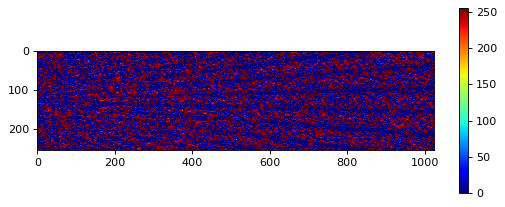

In [52]:
folder_directory = '../Data/Speckle_image/simulation_experiment/star_displacement'
image_path_RG = os.path.join(folder_directory, 'Star_RG_256X1024_120_15.bmp')
ref_image = Image.open(image_path_RG)
ref_gray = ref_image.convert('L')
ref_gray = np.array(ref_gray)
RG = ref_gray

image_path_DG = os.path.join(folder_directory, 'Star_DG_256X1024_120_15.bmp')
def_image = Image.open(image_path_DG)
def_gray = def_image.convert('L')
def_gray = np.array(def_gray)
DG = def_gray

plt.figure(figsize=(8, 3), dpi=80)
plt.imshow(np.abs(RG-DG), cmap='jet', interpolation='nearest')
plt.colorbar()

In [53]:
H, L = RG.shape;
x = np.arange(L)
y = np.arange(H)
X, Y = np.meshgrid(x, y)
pmax=120; pmin=15;  # 控制最左端的条纹数目 和 最右端的条纹数目
pwave=pmin+X*(pmax-pmin)/L
v1 = 0.5*np.cos((Y-H/2)*2*np.pi/(pwave))
# 计算矩阵的最小值和最大值
min_val = np.min(v1)
max_val = np.max(v1)
# 归一化矩阵到[-1, 1]范围
displacement_field_v = 2 * (v1 - min_val) / (max_val - min_val) - 1
displacement_field_u = np.zeros_like(RG)

In [99]:
# 定义ROI区域
ROI = np.zeros_like(DG)
ROI[5:251,5:1019] = 1
y_size, x_size = RG.shape
x_list = np.linspace(-1, 1, x_size)
y_list = np.linspace(-1, 1, y_size)
IX, IY = np.meshgrid(x_list, y_list)
# 网络结构
width = 50
model = PhysicsInformedNN1(RG, DG, ROI, width, IX, IY)
model.set_window(window_size=1, flag=False)

****************over****************
Epoch [1], Loss: 35.93613052368164
Epoch [101], Loss: 35.3917121887207
Epoch [201], Loss: 35.32624053955078
Epoch [301], Loss: 35.06158447265625
Epoch [401], Loss: 34.801841735839844
Epoch [501], Loss: 34.71051025390625
Epoch [601], Loss: 34.50260925292969
Epoch [701], Loss: 32.755680084228516
Epoch [801], Loss: 28.609966278076172
Epoch [901], Loss: 23.15446662902832
Epoch [1001], Loss: 18.739543914794922
Epoch [1101], Loss: 15.053634643554688
Epoch [1201], Loss: 12.950278282165527
Epoch [1301], Loss: 11.21932601928711
Epoch [1401], Loss: 9.730878829956055
Epoch [1501], Loss: 8.827608108520508
Epoch [1601], Loss: 7.851916790008545
Epoch [1701], Loss: 7.022828102111816
Epoch [1801], Loss: 5.815722942352295
Epoch [1901], Loss: 5.315052032470703
Epoch [2001], Loss: 4.982387065887451
Epoch [2101], Loss: 4.625199317932129
Epoch [2201], Loss: 4.093091011047363
Epoch [2301], Loss: 3.8588688373565674
Epoch [2401], Loss: 3.6803359985351562
Epoch [2501], Loss

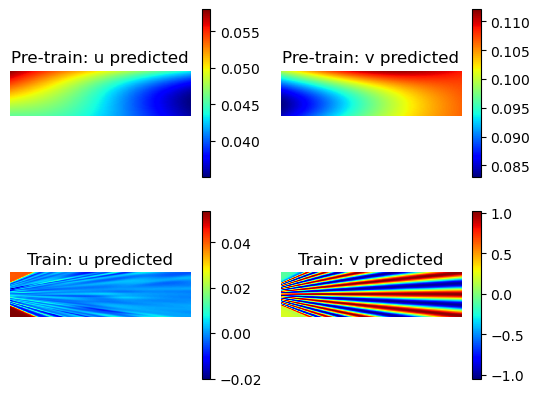

In [100]:
#%% 训练阶段
pretrain_epoch = 0
train_epoch = 6000
model_train(model, IX, IY, pretrain_epoch, train_epoch, 0, 0, new_lr=0.0001)

In [ ]:
u1,v1 = model.predict(IX, IY)
vp = v1[0]
ERROR_v = np.abs(vp-displacement_field_v)
plt.figure(figsize=(8,3), dpi=100)
normu = matplotlib.colors.Normalize(vmin=u_min, vmax=u_max)
normv = matplotlib.colors.Normalize(vmin=v_min, vmax=v_min)
plt.subplot(layout[0], layout[1], 1)
plt.imshow(u1[0], cmap='jet', interpolation='nearest', norm=normu)
plt.colorbar()

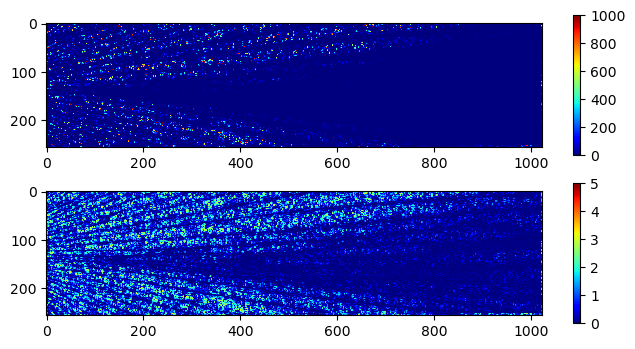

In [45]:
# ERROR_FIG1 = model.abs_error_var()
plt.figure(figsize=(8,4), dpi=100)
norm1 = matplotlib.colors.Normalize(vmin=0, vmax=1000)
norm2 = matplotlib.colors.Normalize(vmin=0, vmax=5)
plt.subplot(2, 1, 1)
plt.imshow(ERROR_FIG1, cmap='jet', interpolation='nearest', norm=norm1)
plt.colorbar()
plt.subplot(2, 1, 2)
plt.imshow(np.log10(1+ERROR_FIG1), cmap='jet', interpolation='nearest', norm=norm2)
plt.colorbar()

In [101]:
lossf_1 = model.lossf_list

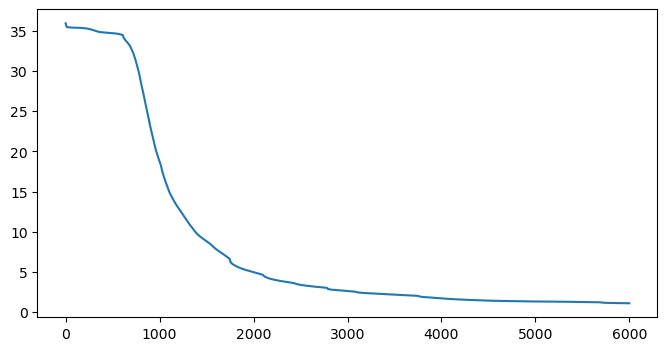

In [102]:
len(lossf_1)
plt.figure(figsize=(8,4), dpi=100)
plt.plot(range(len(lossf_1)), lossf_1)

In [136]:
# 定义ROI区域
ROI = np.zeros_like(DG)
ROI[5:251,5:1019] = 1
y_size, x_size = RG.shape
x_list = np.linspace(-1, 1, x_size)
y_list = np.linspace(-1, 1, y_size)
IX, IY = np.meshgrid(x_list, y_list)
# 网络结构
width = 50
model = PhysicsInformedNN1(RG, DG, ROI, width, IX, IY)

Epoch [1], Loss: 8.227243423461914
Epoch [101], Loss: 8.05504035949707
Epoch [201], Loss: 6.118841171264648
Epoch [301], Loss: 3.2152674198150635
Epoch [401], Loss: 2.56380033493042
Epoch [501], Loss: 2.3349223136901855
Epoch [601], Loss: 2.1359360218048096
Epoch [701], Loss: 1.9769729375839233
Epoch [801], Loss: 1.7369792461395264
Epoch [901], Loss: 1.692811369895935
Epoch [1001], Loss: 1.65655517578125
Epoch [1101], Loss: 1.6283773183822632
Epoch [1201], Loss: 1.6181808710098267
Epoch [1301], Loss: 1.5241457223892212
Epoch [1401], Loss: 1.4645575284957886
Epoch [1501], Loss: 1.4171459674835205
Epoch [1601], Loss: 1.4266595840454102
Epoch [1701], Loss: 1.3761693239212036
Epoch [1801], Loss: 1.3693201541900635
Epoch [1901], Loss: 1.3702418804168701
****************over****************
Epoch [2001], Loss: 4.458019256591797
Epoch [2101], Loss: 3.788050651550293
Epoch [2201], Loss: 3.3114709854125977
Epoch [2301], Loss: 3.008788585662842
Epoch [2401], Loss: 2.8396358489990234
Epoch [2501]

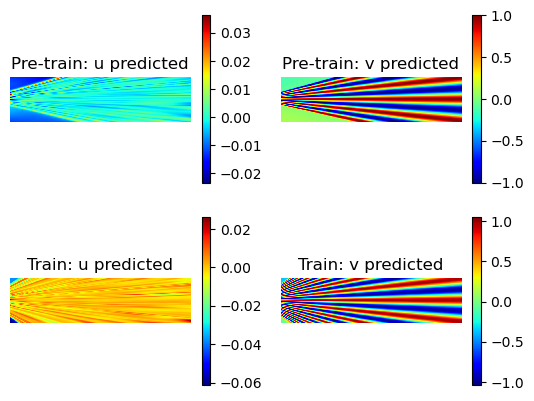

In [137]:
#%% 训练阶段
pretrain_epoch = 2000
train_epoch = 4000
model_train(model, IX, IY, pretrain_epoch, train_epoch, 0, 0, new_lr=0.0005)

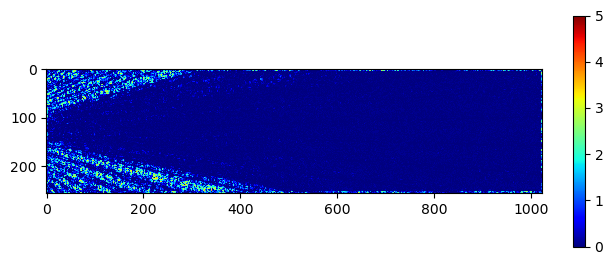

In [47]:
# ERROR_FIG2 = model.abs_error_var()
plt.figure(figsize=(8,3), dpi=100)
norm = matplotlib.colors.Normalize(vmin=0, vmax=5)
plt.imshow(np.log10(1+ERROR_FIG2), cmap='jet', interpolation='nearest', norm=norm)
plt.colorbar()

In [138]:
lossf_2 = model.lossf_list
# loss_2 = [tensor.cpu().detach().numpy() for tensor in lossf_2]
# lossf_2[1].item()
loss_2 = torch.tensor(lossf_2)
lossf_2 = loss_2.cpu().detach().numpy()

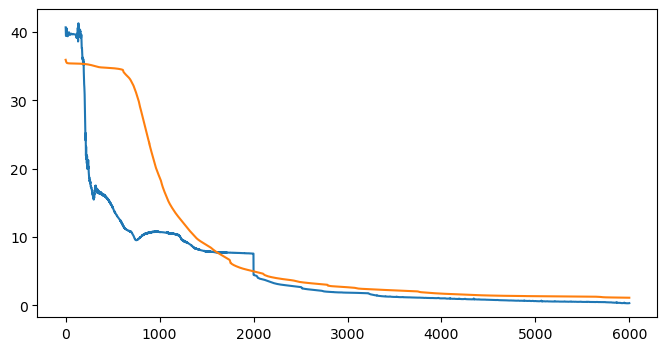

In [139]:
plt.figure(figsize=(8,4), dpi=100)
plt.plot(range(len(lossf_2)), lossf_2)
plt.plot(range(len(lossf_1)), lossf_1)

In [141]:
import scipy
# 创建一些示例数据
loss = {
    'loss1': lossf_1,
    'loss2': lossf_2
}

# 保存数据到.mat文件
scipy.io.savemat('loss.mat', loss)